## Библиотеки 

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from gensim.models import Word2Vec
import keras
from keras import layers as L

## Функции

In [2]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

## Получение данных

In [3]:
df_train = pd.read_csv('df_train.csv', sep=';')
df_test = pd.read_csv('df_test.csv', sep=';')

In [4]:
df_train['Data'] = df_train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = df_train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = df_test.Data.apply(lambda s: list(map(int, s.split(','))))

In [5]:
n_sequences = len(df_train) + len(df_test)
n_timesteps = 2000
n_outputs = 10
n_features = 8

all_data = [df_train.Data[i] + df_train.Target[i] for i in range(len(df_train))] + list(df_test['Data'].values)
w2v_model = Word2Vec(sentences=all_data, vector_size=n_features, window=5, min_count=1, workers=6)

pad = np.zeros(n_features)
X = np.empty((n_sequences, n_timesteps, n_features))
y = np.empty((n_sequences, n_outputs, n_features))

for i, seq in enumerate(all_data):
    seq = seq[-(n_timesteps + n_outputs):]
    pad_length = n_timesteps + n_outputs - len(seq)
    seq = [w2v_model.wv[x] for x in seq]
    X[i] = seq[:-10] + [pad]*pad_length
    y[i] = seq[-10:]

X.shape, y.shape

((14066, 2000, 8), (14066, 10, 8))

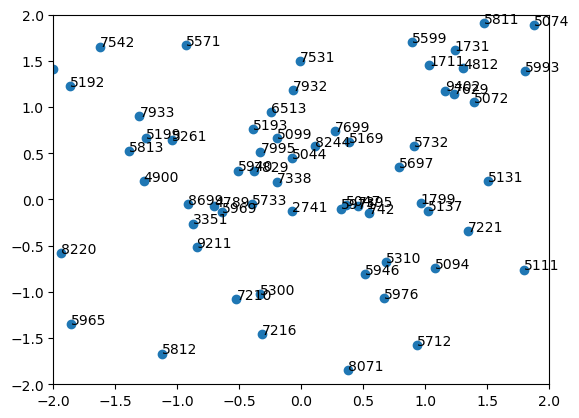

In [6]:
from sklearn.decomposition import PCA

codes = w2v_model.wv.key_to_index
pca = PCA(n_components=2)
result = pca.fit_transform(w2v_model.wv[codes])

plt.scatter(result[:, 0], result[:, 1])

for i, code in enumerate(list(codes)):
    plt.annotate(code, xy=(result[i, 0], result[i, 1]))

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

In [7]:
model = keras.models.Sequential()
model.add(L.Masking(mask_value=0., input_shape=(n_timesteps, n_features)))
model.add(L.LSTM(256, activation='tanh', dropout=0.5))
model.add(L.LayerNormalization())
model.add(L.RepeatVector(n_outputs))
model.add(L.LSTM(512, activation='tanh', return_sequences=True, dropout=0.5))
model.add(L.TimeDistributed(L.Dense(128, activation='relu')))
model.add(L.TimeDistributed(L.Dense(n_features)))

model.compile(optimizer='nadam', loss='mse')

model.fit(X, y, epochs=10, batch_size=64, verbose=1, workers=-1)

Epoch 1/10
217/220 [============================>.] - ETA: 1:16 - loss: 6.1114

KeyboardInterrupt: 

In [ ]:
def lstm_predict(seq):
    seq = seq[-n_timesteps:]
    pad_length = n_timesteps - len(seq)
    pred_vectors = model.predict(np.array([[pad]*pad_length + [w2v_model.wv[x] for x in seq]]), verbose=0)[0]
    preds = [w2v_model.wv.most_similar(positive=[x], topn=1)[0][0] for x in pred_vectors]
    return preds

In [ ]:
def lstm_predict_by_first(seq):
    seq = seq[-n_timesteps:]
    pad_length = n_timesteps - len(seq)
    pred_vector = model.predict(np.array([[pad]*pad_length + [w2v_model.wv[x] for x in seq]]), verbose=0)[0][0]
    preds = [x[0] for x in w2v_model.wv.most_similar(positive=[pred_vector], topn=10)]
    return preds

In [ ]:
df_train['pred_lstm'] = df_train['Data'].apply(lstm_predict)
print(mapk(df_train['Target'], df_train['pred_lstm']))

In [ ]:
df_train['pred_lstm'] = df_train['Data'].apply(lstm_predict_by_first)
print(mapk(df_train['Target'], df_train['pred_lstm']))

In [ ]:
# df_test['Predicted'] = df_test['Data'].apply(lstm_predict_by_first)

# submission = df_test[['Id', 'Predicted']]
# submission['Predicted'] = submission['Predicted'].astype(str).str.replace(',', '')
# submission.to_csv('submission_lstm_9.csv', index=False)